In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Setup

In [2]:
import os
import pandas as pd
import ffmpeg
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [5]:
AUDIOS_DIR_PATH = "res/mp3_data"
ORIGINAL_CSV_PATH = "res/original_samples.csv"
NEW_CSV_PATH = "res/samples.csv"

# Dataset Exploration

In [7]:
df = pd.read_csv(ORIGINAL_CSV_PATH)
print(f"The dataset contains {len(df)} samples")
df.head()

The dataset contains 29220 samples


,path,genre,category,subcategory,key type,key signature,time signature,beat count,Single,Ensemble,...,Acoustic,Electric,Melodic,Dissonant,Relaxed,Intense,Part,Fill,Cheerful,Dark
0,01 Hip Hop/Abandoned Brass Stabs.caf,Hip Hop,Trumpet,Trumpet,minor,E,4/4,8.0,True,False,...,False,True,True,False,False,False,True,False,False,True
1,01 Hip Hop/Abandoned Orchestral Layers.caf,Hip Hop,Timpani,Timpani,minor,E,4/4,16.0,False,True,...,False,True,False,False,False,True,True,False,False,True
2,01 Hip Hop/Afloat Beat.caf,Hip Hop,Electronic Beats,Electronic Beats,NaN,NaN,4/4,32.0,True,False,...,False,True,False,False,False,False,True,False,False,False
3,01 Hip Hop/Afloat Pad.caf,Hip Hop,Synthesizer,Synthesizer,minor,C,4/4,32.0,True,False,...,False,True,True,False,True,False,True,False,False,False
4,01 Hip Hop/Afloat Sub Bass.caf,Hip Hop,Synthetic Bass,Synthetic Bass,minor,C,4/4,32.0,True,False,...,False,True,True,False,False,False,True,False,False,False


## Audio Files

First, I replace the extension as the source file are listed a `.caf`, while I'm using `.mp3`

In [ ]:
df["path"] = df["path"].apply(lambda x: x.replace(".caf", ".mp3"))

I then collect and plot the duration of each mp3 file to get an understanding of the size of the dataset

In [10]:
durations = []
for path in tqdm(df["path"]):
    out = ffmpeg.probe(os.path.join(AUDIOS_DIR_PATH, path))
    dur = out['format']['duration']
    durations.append(float(dur))

100%|██████████| 29220/29220 [1:04:06<00:00,  7.60it/s]


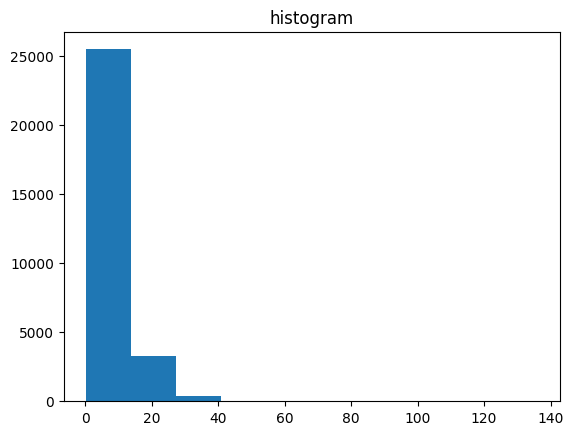

In [31]:
data, bins = np.histogram(durations)

plt.hist(durations, bins=bins) 
plt.title("Audio Durations") 
plt.show()

The great majority of the examples have a duration under 30 seconds, as a starting criterion, we could safely filter out longer samples from the dataset as they're a very little portion of the whole and may slow down every computation

In [33]:
df = df[df["duration"] < 30]
print(f"{len(df)} examples left")

28935 examples left


Save the updated DataFrame into a new file:

In [36]:
df.to_csv(NEW_CSV_PATH)

## Classes

In [22]:
df = pd.read_csv(NEW_CSV_PATH)

The dataset contains various features, this work focuses on `genre` and `category`, so it makes sense to filter out rows containing no value for those two columns

In [23]:
from src.dataset import DATASET_FEATURES

drop_features = [f for f in DATASET_FEATURES if f not in ["genre", "category"]]
df = df.drop(columns=drop_features)
df = df[~df.isna().any(axis=1)]
print(f"{len(df)} examples left")
df.head()

27206 examples left


,path,genre,category,id,duration
0,01 Hip Hop/Abandoned Brass Stabs.mp3,Hip Hop,Trumpet,01_Hip_Hop_Abandoned_Brass_Stabs,7.262041
1,01 Hip Hop/Abandoned Orchestral Layers.mp3,Hip Hop,Timpani,01_Hip_Hop_Abandoned_Orchestral_Layers,14.445714
2,01 Hip Hop/Afloat Beat.mp3,Hip Hop,Electronic Beats,01_Hip_Hop_Afloat_Beat,19.670204
3,01 Hip Hop/Afloat Pad.mp3,Hip Hop,Synthesizer,01_Hip_Hop_Afloat_Pad,19.670204
4,01 Hip Hop/Afloat Sub Bass.mp3,Hip Hop,Synthetic Bass,01_Hip_Hop_Afloat_Sub_Bass,19.670204


### Genre

In [80]:
genre_counts = df.value_counts("genre")

print("="*50)
print("Genre")
print("-"*50)
print(genre_counts.describe())

Genre
--------------------------------------------------
count      31.000000
mean      877.612903
std      1057.612710
min        13.000000
25%       314.000000
50%       445.000000
75%       828.500000
max      3977.000000
dtype: float64


<Axes: xlabel='genre'>

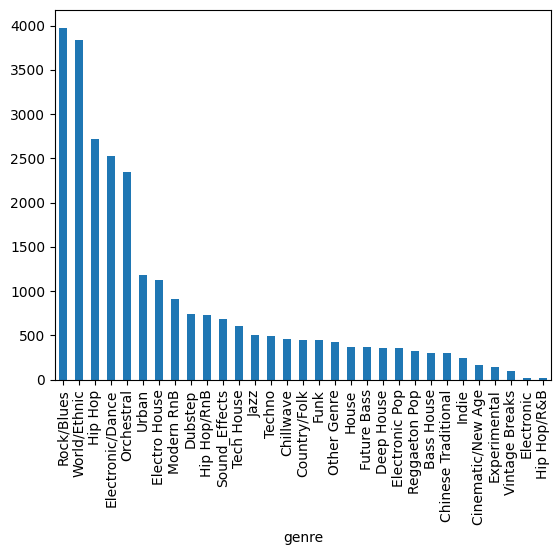

In [83]:
genre_counts.plot(kind='bar')

Yada yada yada

In [84]:
df = df[df["genre"].isin(df.value_counts("genre", sort=True)[:6].index)]
df.value_counts("genre")

genre
Rock/Blues          3977
World/Ethnic        3834
Hip Hop             2723
Electronic/Dance    2528
Orchestral          2346
Urban               1184
dtype: int64

### Category

In [103]:
category_counts = df.value_counts("category")

print("="*50)
print("Category")
print("-"*50)
print(category_counts.describe())

Category
--------------------------------------------------
count      63.000000
mean      263.365079
std       609.067646
min         1.000000
25%         3.000000
50%        11.000000
75%        95.500000
max      3268.000000
dtype: float64


In [104]:
# category_counts[category_counts < 10]

# category_counts.plot(kind='bar')
grouped_categories = category_counts[category_counts < 300]
category_counts = category_counts.drop(grouped_categories.index)
category_counts["other"] = grouped_categories.sum()

<Axes: xlabel='category'>

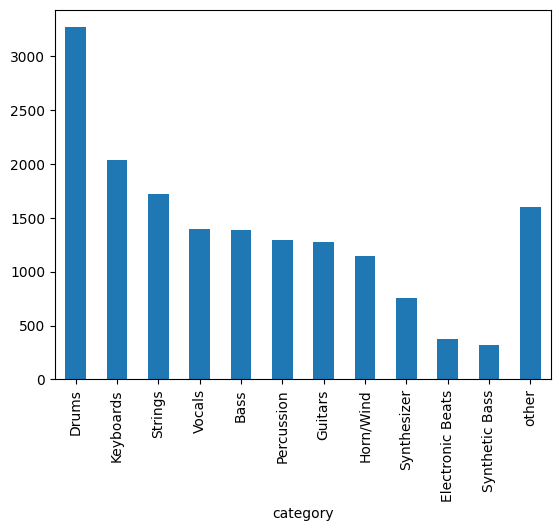

In [107]:
category_counts.plot(kind='bar')

In [109]:
df = df[df["category"].isin(df.value_counts("category", sort=True)[:8].index)]
df.value_counts("category")

category
Drums         3268
Keyboards     2040
Strings       1724
Vocals        1393
Bass          1391
Percussion    1299
Guitars       1273
Horn/Wind     1150
dtype: int64

## Samples

In [113]:
from src.dataset import get_dataset, add_audio_column

ds = get_dataset(df.sample(20))
ds = add_audio_column(ds, AUDIOS_DIR_PATH, sampling_rate=16_000)
ds

Dataset({
    features: ['path', 'genre', 'category', 'id', 'duration', 'cluster', 'cluster_genre', 'cluster_category', 'audio'],
    num_rows: 20
})

In [114]:
from src.utils import play_random_audios

play_random_audios(ds, quantity=3, label_maps=, print_features=["genre", "category"])

## Feature Extraction

In [121]:
# temporaneamente per vedere se ha scaricato bene i chunk
import datasets

wav2vec2_base = "res/DriveDelirium/wav2vec2/ds-wav2vec2"
whisper_base = "res/DriveDelirium/whisper/ds-whisper"

In [ ]:
chunk = datasets.load_from_disk(wav2vec2_base + "-chunk1")

# s = 7234 + 
chunk

In this work, two different yada are taken into account:

In [ ]:
from src.train import get_preprocess_func

wav2vec2_encode = get_preprocess_func({
    "feature_encoder": "wav2vec2"
})
whisper_encode = get_preprocess_func({
    "feature_encoder": "whisper"
})

### Normalized Wave

In [ ]:
ds = ds.map(wav2vec2_encode, batched=True)
ds

### Mel-Spectrogram

In [ ]:
ds = ds.map(whisper_encode, batched=True)
ds